# 读取数据

In [1]:
import pickle
road_zip={}
orthogonal_list={}
node_dict={}
node_dict_amap={}
way_list=[]
with open('road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
with open('map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('map_ways.pkl','rb') as f:
    way_list=pickle.load(f)
way_vertex_list=[]
for way in way_list:
    vertex_list=[]
    for node in way[1]:
        if node in orthogonal_list:
            vertex_list.append(node)
    if len(vertex_list)>0:
        way_vertex_list.append((way[0],vertex_list))
way_vertex_dict={}
for way in way_vertex_list:
    if way[0] not in way_vertex_dict:
        way_vertex_dict[way[0]]=way[1]
    else:
        way_vertex_dict[way[0]].extend(way[1])
for way in way_vertex_dict:
    way_vertex_dict[way]=list(set(way_vertex_dict[way]))
node_id2no={Id:No for No,Id in enumerate(orthogonal_list)}
node_no2id={No:Id for No,Id in enumerate(orthogonal_list)}

class edge_item:
    def __init__(self,vi,vj):
        self.position=(vi,vj)
        self.exist=False
        self.rname=''
        self.roads=[]
    
adj_matrix={vi:{vj:edge_item(vi,vj) for vj in orthogonal_list} for vi in orthogonal_list}
for key,value in orthogonal_list.items():
    vi=key
    edges=value[0]+value[1]
    for edge in edges:
        vj=edge[1]
        adj_matrix[vi][vj].exist=True
        adj_matrix[vi][vj].rname=edge[0]

1
2


# 将高德路段与拓扑图对应

In [2]:
#从道路方向信息中解析出道路的起讫点
def decodeDirection(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end
def findRelatedEdges(name,s,d):
    sv_list,dv_list=[],[]
    for v in way_vertex_dict[name]:
        for e in adj_matrix[v].values():
            if e.exist and e.rname==s:
                sv_list.append(v)
            if e.exist and e.rname==d:
                dv_list.append(v)

    related_edges=[]
    #能找到起讫点
    if len(sv_list)>0 and len(dv_list)>0:
        route=[]
        for sv in sv_list:
            history_v=[sv]
            answer_v=[]
            next_seq=[[sv]]
            while len(next_seq)>0:
                seq=next_seq.pop()
                v=seq[-1]
                for e in adj_matrix[v].values():
                    if e.exist and e.rname==name and e.position[1] not in history_v:
                        history_v.append(e.position[1])
                        if e.position[1] in dv_list:
                            answer_v.append(seq+[e.position[1]])
                        else:
                            next_seq.append(seq+[e.position[1]])
            route.extend(answer_v)
        if len(route)==0:
            print(name,s,d,'有起讫点但找不到路径')
            # 则将所有路段纳入相关边
            for vi in way_vertex_dict[name]:
                for vj,e in adj_matrix[vi].items():
                    if e.exist and e.rname==name:
                        if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                            related_edges.append((vi,vj))
                        elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                            related_edges.append((vj,vi))
                        
        for rt in route:
            for i in range(1,len(rt)):
                vi,vj=rt[i-1],rt[i]
                if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                    related_edges.append((vi,vj))
                elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                    related_edges.append((vj,vi))
    #找不到起讫点，则将所有路段纳入相关边
    else:
        for vi in way_vertex_dict[name]:
            for vj,e in adj_matrix[vi].items():
                if e.exist and e.rname==name:
                    if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                        related_edges.append((vi,vj))
                    elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                        related_edges.append((vj,vi))
    if len(related_edges)==0:
        print('error')
    return related_edges

In [3]:
roads=list(road_zip.keys())
road_edges={}
for road in roads:
    if road[0] in way_vertex_dict:
        begin,end=decodeDirection(road[1])
        related_edges=findRelatedEdges(road[0],begin,end)
        if len(related_edges)>0:
            road_edges[road]=related_edges

for road,edges in road_edges.items():
    for edge in edges:
        vi,vj=edge[0],edge[1]
        adj_matrix[vi][vj].roads.append(road)

通耀路 耀龙路 世博馆路 有起讫点但找不到路径
通耀路 世博馆路 耀龙路 有起讫点但找不到路径
齐河路 杨高南路 云台路 有起讫点但找不到路径
北艾路 杨高南路 高科西路 有起讫点但找不到路径
北艾路 高科西路 杨高南路 有起讫点但找不到路径
双桥路 金高路 张杨北路 有起讫点但找不到路径
芙蓉江路 虹古路 长宁路 有起讫点但找不到路径
芙蓉江路 长宁路 虹古路 有起讫点但找不到路径
同普路 泾阳路 中江路 有起讫点但找不到路径
丰庄路 金沙江路 曹安公路 有起讫点但找不到路径
丰庄路 曹安公路 金沙江路 有起讫点但找不到路径
国权路 黄兴路 四平路 有起讫点但找不到路径
政民路 武东路 淞沪路 有起讫点但找不到路径
政民路 淞沪路 武东路 有起讫点但找不到路径
武川路 纪念路 政立路 有起讫点但找不到路径
武川路 政立路 纪念路 有起讫点但找不到路径
江场路 奎照路 粤秀路 有起讫点但找不到路径
江场路 粤秀路 奎照路 有起讫点但找不到路径
虬江路 四川北路 四川北路 有起讫点但找不到路径
武胜路 黄陂北路 西藏中路 有起讫点但找不到路径
银城中路 浦东南路 东昌路 有起讫点但找不到路径
福建北路 福建中路 海宁路 有起讫点但找不到路径
福建北路 海宁路 福建中路 有起讫点但找不到路径
天潼路 浙江北路 大名路 有起讫点但找不到路径
东汉阳路 溧阳路 新建路 有起讫点但找不到路径
东汉阳路 新建路 溧阳路 有起讫点但找不到路径
武定路 江宁路 武宁南路 有起讫点但找不到路径


## 数据增强

In [10]:
from math import acos,cos,sin
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

connect_dist=2 # km
def distance(c1,c2):
    if c1==c2:
        return 0
    else:
        c1=(float(c1[0]),float(c1[1]))
        c2=(float(c2[0]),float(c2[1]))
        return 6371.004*acos(cos(c1[1])*cos(c2[1])*cos(c1[0]-c2[0])+sin(c1[1])*sin(c2[1]))
no=0
ref=node_dict_amap
spatial_maps=adj_matrix
bar = ProgressBar(widgets=widgets, maxval=len(node_no2id)).start()
for i in range(len(node_no2id)-1):
    vi=node_no2id[i]
    for j in range(i+1,len(node_no2id)):
        vj=node_no2id[j]
        if not adj_matrix[vi][vj].exist and distance(ref[vi],ref[vj])<=connect_dist:# or spatial_maps[vi][vj].exist and len(spatial_maps[vi][vj].roads)==0:
            for vj_d in spatial_maps[vj]:
                if spatial_maps[vj][vj_d].exist and vi!=vj_d and not spatial_maps[vi][vj_d].exist:
                    spatial_maps[vi][vj_d]=spatial_maps[vj][vj_d]
                    spatial_maps[vj_d][vi]=spatial_maps[vj_d][vj]
            for vi_d in spatial_maps[vi]:
                if spatial_maps[vi][vi_d].exist and vj!=vi_d and not spatial_maps[vj][vi_d].exist:
                    spatial_maps[vj][vi_d]=spatial_maps[vi][vi_d]
                    spatial_maps[vi_d][vj]=spatial_maps[vi_d][vi] 
            no+=1
    bar.update(i+1)
bar.finish()
print(no)

806


In [ ]:
import pickle
with open('road_edges.pkl','wb') as f:
    pickle.dump(road_edges,f)

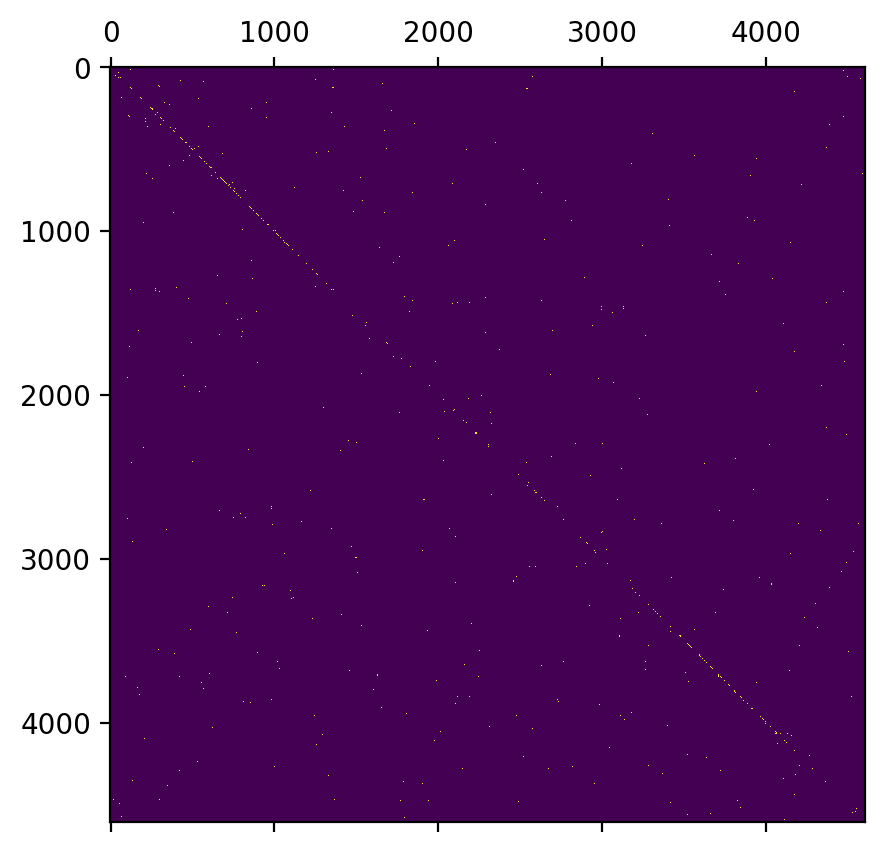

In [11]:
import numpy as np
matrix=[[0 for _ in range(len(spatial_maps))] for _ in range(len(spatial_maps))]
for i in range(len(spatial_maps)):
    for j in range(len(spatial_maps)):
        if spatial_maps[node_no2id[i]][node_no2id[j]].exist:
            matrix[i][j]=1
# 绘制矩阵            
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.matshow(matrix)
fig.show()
# import cv2 as cv
# sample=np.array(matrix)
# image=255*sample
# cv.imwrite("graph_martix.png", image)

绘制匹配路段图

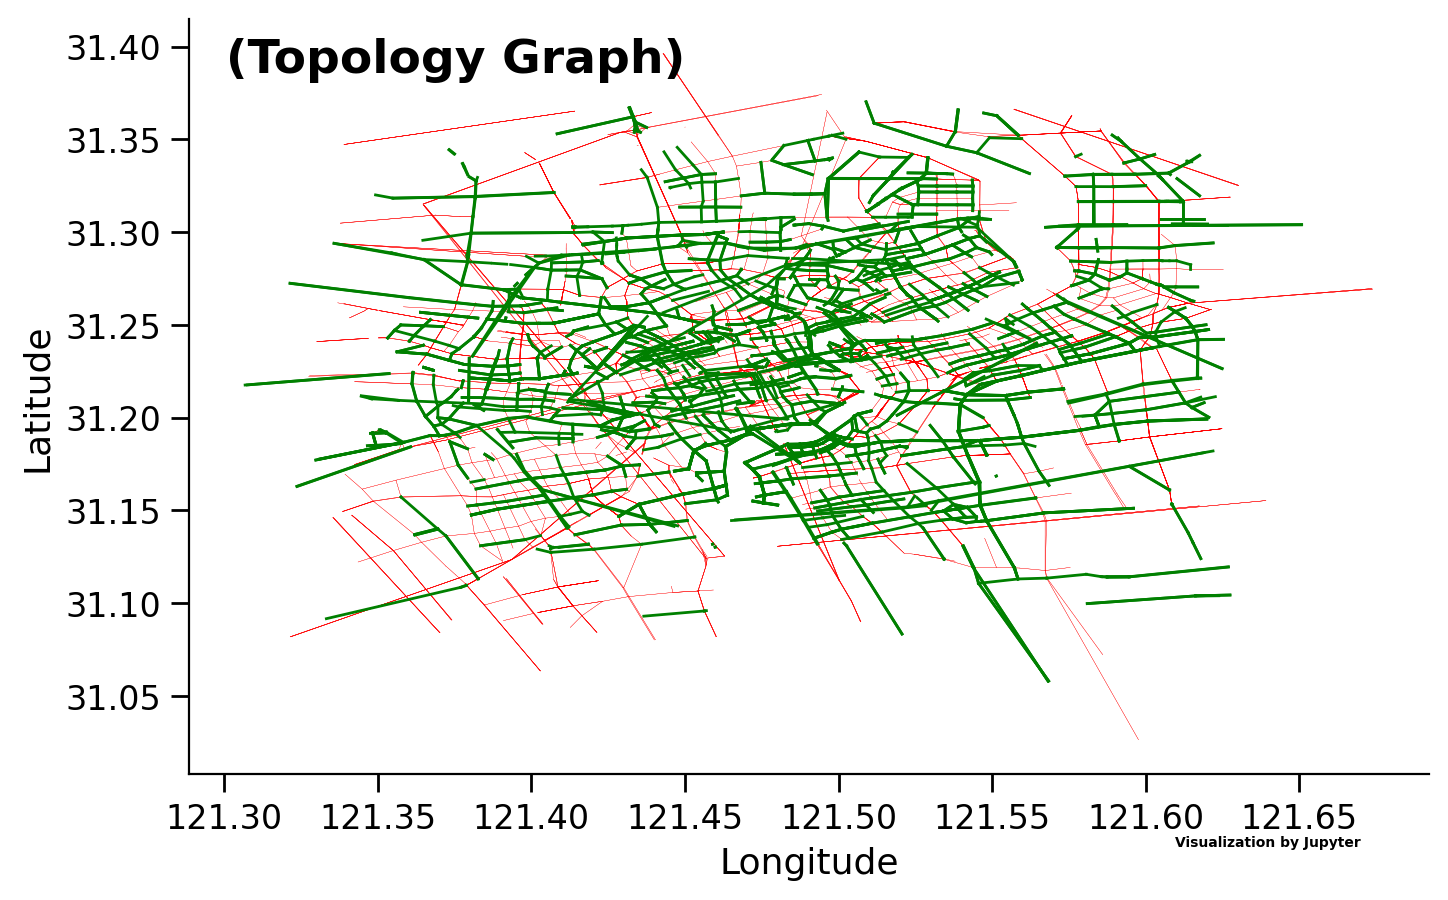

In [13]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for vi in spatial_maps:
    for vj,e in spatial_maps[vi].items():
        if e.exist:
            ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='r',linewidth=.1)
for road,edges in road_edges.items():
    for edge in edges:
        vi,vj=edge[0],edge[1]
        ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='g',linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Topology Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 模式挖掘

In [12]:
import numpy as np
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
data=data.swapaxes(0,1)#date,road,time,regular_speed
data=np.concatenate(data,axis=1)#road,datetime,regular_speed
data=data.T#datetime,road,regular_speed
influence_matrix=[[0 for j in range(len(road_zip))] for i in range(len(road_zip))]
k=4    #k代表检查当前时间点之前kT范围内所有产生拥堵的路段
g=2    #g代表将当前道路的g阶邻居纳入检查范围
old_cjst_group=[[] for _ in range(k)]    #前kT时间段内曾经发生拥堵的道路集合，每个T各成一个列表
new_cjst=[]    #记录当前时间内发生拥堵的路段
#按照时间遍历
bar = ProgressBar(widgets=widgets, maxval=len(data)).start()
for t,Tdata in enumerate(data):
    new_cjst=[]    #清空新拥堵道路集合
    old_cjst=[]    #构建历史拥堵道路集合
    for cjst in old_cjst_group:
        old_cjst.extend(cjst)
    old_cjst=list(set(old_cjst))
    #按照道路遍历
    for i,Rdata in enumerate(Tdata):
        #如果道路发生了拥堵
        if Rdata<=0.5 and Rdata!=0.0:
            road=list(road_zip.keys())[i]
            #将道路的对应矩阵的值增加
            influence_matrix[i][i]+=1
            #如果道路拥堵是新发生的
            if road not in old_cjst:
                #通过广度优先遍历当前道路的g阶邻居道路并筛选出曾经拥堵的g阶邻居
                roads_stack=[road]
                adj_roads=[]
                for _ in range(g):
                    new_roads_stack=[]
                    while len(roads_stack)>0:
                        current=roads_stack.pop()
                        if current not in road_edges:
                            continue
                        for edge in road_edges[current]:
                            vi,vj=edge[0],edge[1]
                            checked_edges=list(spatial_maps[vi].values())+list(spatial_maps[vj].values())
                            for e in checked_edges:
                                if e.exist:
                                    for road in e.roads:
                                        if road!=current and road not in adj_roads and road in old_cjst:
                                            adj_roads.append(road)
                                            new_roads_stack.append(road)
                    roads_stack=new_roads_stack
                #每一个曾经拥堵的祖先道路都对当前道路施加影响，将对应的矩阵的边的值增加
                for adj_road in adj_roads:
                    influence_matrix[list(road_zip.keys()).index(adj_road)][i]+=1
            new_cjst.append(road)
    #更新历史拥堵道路
    for i in range(1,k):
        old_cjst_group[i-1]=old_cjst_group[i]
    old_cjst_group[k-1]=new_cjst
    bar.update(t+1)
bar.finish()

Progress: 100% |##############| Elapsed Time: 2:39:23 Time: 2:39:23   0.45  B/s


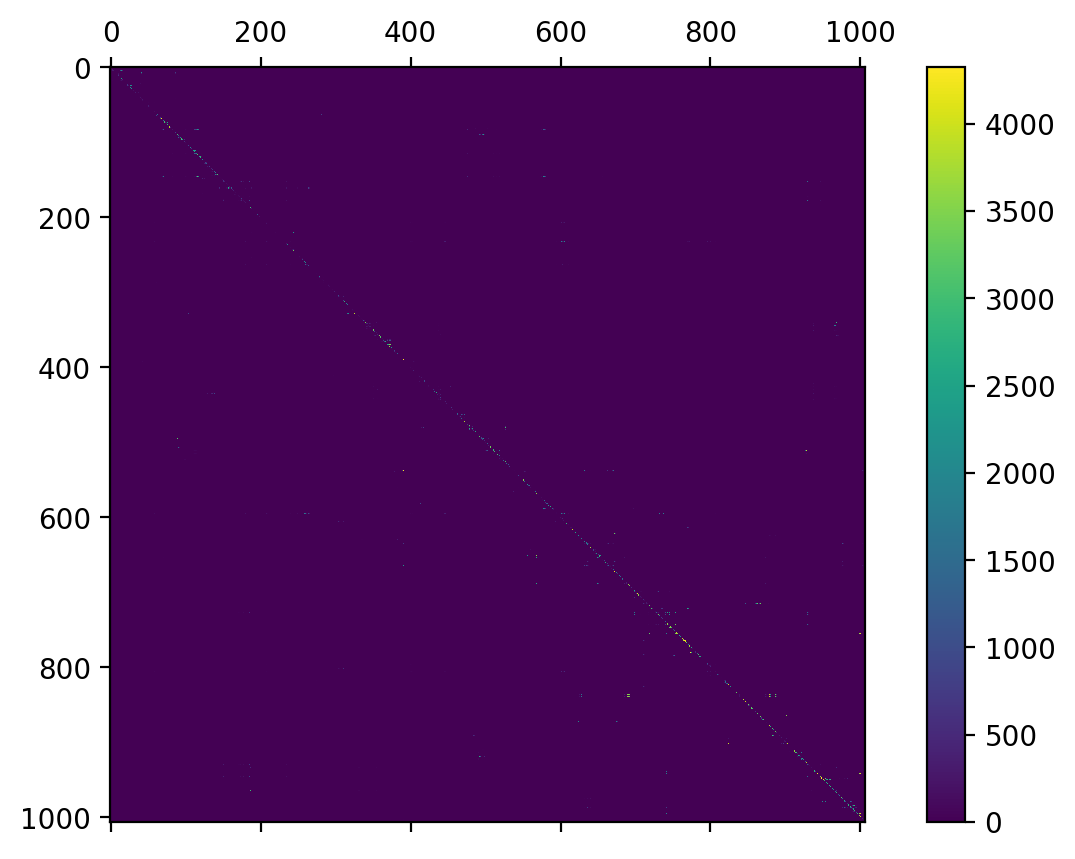

In [19]:
#绘制矩阵
import matplotlib.pyplot as plt
from matplotlib import cm,colors
minium,maxium=min(np.array(influence_matrix).flatten()),max(np.array(influence_matrix).flatten())
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.matshow(influence_matrix)
norm=colors.Normalize(vmin=minium, vmax=maxium)
im=cm.ScalarMappable(norm=norm, cmap='viridis')
fig.colorbar(im,ax=ax) 
fig.show()
# import cv2 as cv
# sample=np.array(influence_matrix)
# sample=np.int64(sample>0)
# sample=255.0*sample
# cv.imwrite("influence_matrix.png", sample)

关键路段共有： 289


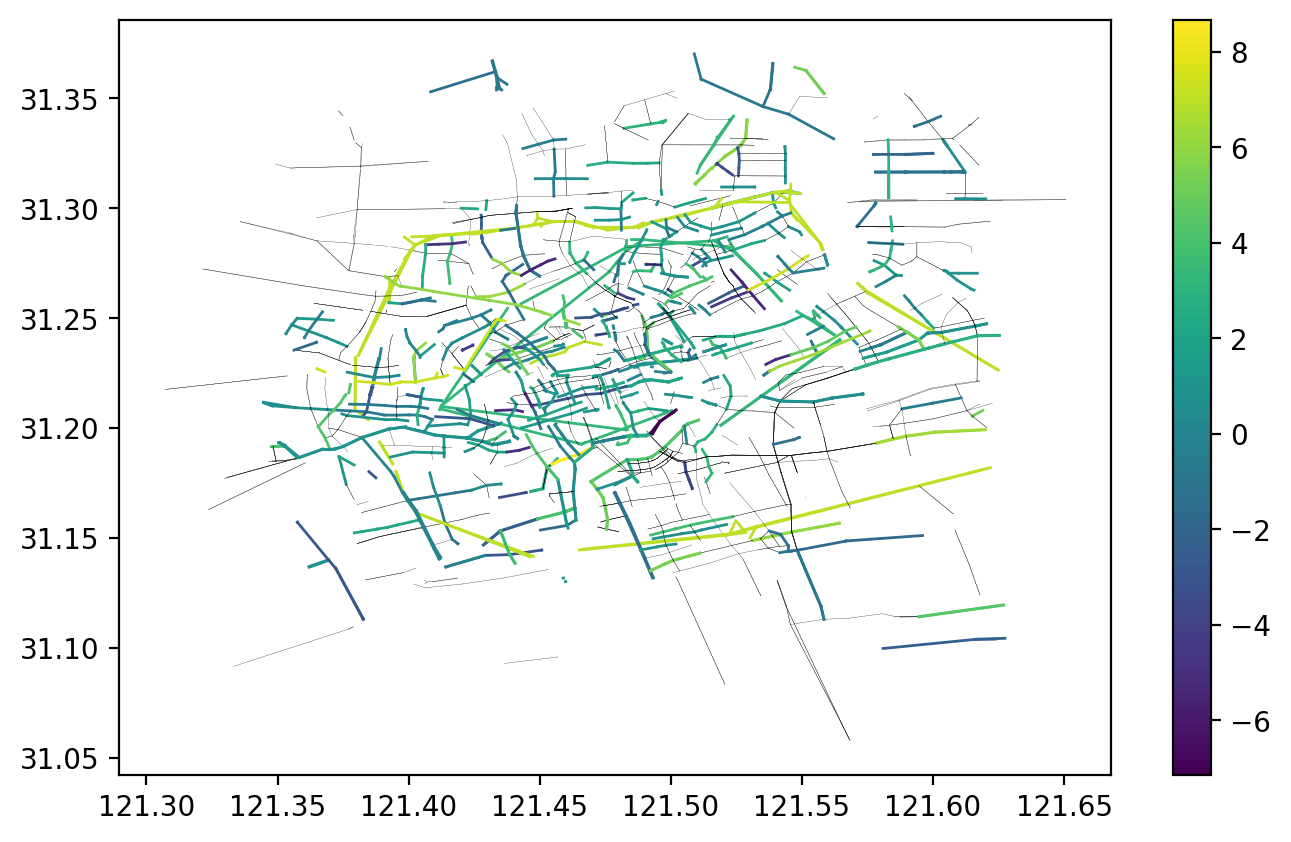

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm,colors
critical_road={}
for i in range(len(influence_matrix)):
    if np.sum(influence_matrix[i])-influence_matrix[i][i] and influence_matrix[i][i]!=0:
        critical_road[list(road_zip.keys())[i]]=np.log(float(np.sum(influence_matrix[i])-influence_matrix[i][i])/float(influence_matrix[i][i]))
print('关键路段共有：',len(critical_road))
maxium,minium=max(critical_road.values()),min(critical_road.values())
ref=node_dict_amap
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
cmap = cm.get_cmap('viridis', 100)
for road in road_zip.keys():
    if road not in road_edges:
        continue
    for edge in road_edges[road]:
        vi,vj=edge[0],edge[1]
        if road in critical_road:
            ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color=cmap((critical_road[road]-minium)/(maxium-minium)),linewidth=1)
        else:
            ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='black',linewidth=.1)
norm = colors.Normalize(vmin=minium, vmax=maxium)
im = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im,ax=ax) 
fig.show()

# 事件挖掘

In [89]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,:]#road,date,time,[status, regular_speed]
data=data.reshape((-1,2))#[status, regular_speed]
status1=np.array([item[1] for item in data if item[0]==1])
status2=np.array([item[1] for item in data if item[0]==2])
print(len(status1),len(status2))

4237949 78164


In [90]:
speed_threshold=0.0
step=0.01
for _ in range(1000):
    rate1=np.sum(status1>speed_threshold)/len(status1)
    rate2=np.sum(status2<speed_threshold)/len(status2)
    if rate1>rate2:
        speed_threshold+=step
    elif rate1<rate2:
        speed_threshold-=step
print(speed_threshold)

0.5000000000000002


In [61]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
cjstT=0.5
g=1
root_cjst=[]
for date in range(data.shape[1]):
    for time in range(1,data.shape[2]):
        for rid in range(data.shape[0]):
            if 0<data[rid][date][time]<cjstT:
                road=list(road_zip.keys())[rid]
                if road not in road_edges:
                    continue
                is_root=True
                stack=[]
                if len(road_edges[road])==0:
                    print('error: 存在len(road_edges[road])==0')
                for edge in road_edges[road]:
                    stack.append(edge[0])
                    stack.append(edge[1])
                stack=list(set(stack))
                history=[]
                #通过广度优先遍历当前道路的g阶邻居道路
                for _ in range(g):
                    new_stack=[]
                    while len(stack)>0 and is_root:
                        v=stack.pop()
                        if v in history:
                            continue
                        else:
                            history.append(v)
                            checked_edges=[e for e in list(spatial_maps[v].values()) if e.exist]
                            for edge in checked_edges:
                                for r in edge.roads:
                                    if r!=road and 0<road_zip[r][date][time-1][1]<cjstT:
                                        is_root=False
                                        break
                                if not is_root:
                                    break
                                new_stack.append(edge.position[1])
                    stack=new_stack
                    if not is_root:
                        break
                if is_root:
                    root_cjst.append({'date':date,'time':time,'rid':rid})
    break

In [106]:
from copy import deepcopy
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

class event:
    def __init__(self):
        self.date=0        # 事件发生日期
        self.start_time=0  # 事件开始时间
        self.end_time=0    # 事件结束时间
        self.cjst_seq=[]   # 时间过程，{时间, 拥堵路段列表}
cjstT=0.5
empty_tolerance=2
cjst_events=[]
bar = ProgressBar(widgets=widgets, maxval=len(root_cjst)).start()
# 遍历每一个拥堵事件源
for i,root in enumerate(root_cjst):
    # 如果该拥堵事件源在早些时刻已经被记录则直接跳过
    if {'date':root['date'],'time':root['time']-1,'rid':root['rid']} in root_cjst:
        continue
    # 初始化拥堵事件
    new_event=event()
    new_event.date=root['date']
    new_event.start_time=root['time']
    new_event.cjst_seq.append({'time':root['time'],'rids':[root['rid']]})
    # 从拥堵事件的起始时间开始向后推演
    former_edge=[]
    for time in range(new_event.start_time+1,data.shape[2]):
        old_snapshot=new_event.cjst_seq[-1]
        new_snapshot={'time':time,'rids':[]}
        # 考察上一个快照，将拥堵持续到当前的路段加入当前快照
        for rid in old_snapshot['rids']:
            if 0<data[rid][new_event.date][time]<cjstT:
                new_snapshot['rids'].append(rid)
                
        # 考察上一快照通过无信息路段传播的拥堵
        for e in former_edge:
            # 如果节点所连接的路段发生了拥堵，则加入到当前的拥堵快照中
            for road in e.roads:
                 if 0<road_zip[road][new_event.date][time][1]<cjstT:
                    new_snapshot['rids'].append(list(road_zip.keys()).index(road))
        former_edge=[]
        
        # 上一快照的所有路段都有传播拥堵的可能系，因此将上一快照的所有节点纳入stack
        history=[]
        stack=[]
        for rid in old_snapshot['rids']:
            road=list(road_zip.keys())[rid]
            for edge in road_edges[road]:
                stack.append(edge[0])
                stack.append(edge[1]) 
        stack=set(list(stack)) # 去重
        while len(stack)>0:
            v=stack.pop()
            if v in history:
                continue
            else:
                history.append(v)
                checked_edges=[e for e in list(spatial_maps[v].values()) if e.exist]
                for e in checked_edges:
                    # 如果节点所连接的路段发生了拥堵，则加入到当前的拥堵快照中
                    if len(e.roads)!=0:
                        for r in e.roads:
                            if road_zip[r][new_event.date][time][1]<cjstT:
                                new_snapshot['rids'].append(list(road_zip.keys()).index(r))
                    # 如果这个路段没有路况信息，则考虑路段的另一个端点
                    else:
                        candidate=list(spatial_maps[e.position[1]].values())
                        for _ in range(empty_tolerance):
                            next_candidate=[]
                            for fe in candidate:
                                if fe.exist and fe!= e and fe not in former_edge:
                                    former_edge.append(fe)
                                    if len(fe.roads)==0:
                                        next_candidate.extend(list(spatial_maps[fe.position[1]].values()))
                            candidate=next_candidate
                            
        former_edge=list(set(former_edge))
        new_snapshot['rids']=list(set(new_snapshot['rids'])) # 去重
        if len(new_snapshot['rids'])>0:
            new_event.cjst_seq.append(new_snapshot)
        else:
            new_event.end_time=time
            break
    bar.update(i+1)
    if new_event.end_time==0 or new_event.end_time-new_event.start_time>24:
        new_event.end_time=data.shape[2]
        continue
    for snapshot in new_event.cjst_seq:
        if len(snapshot['rids'])>1:
            cjst_events.append(new_event)
            break
bar.finish()

KeyboardInterrupt: 

## OVERVIEW

In [64]:
# overview
print('total number of events is:',len(cjst_events))
count=0
for no,event in enumerate(cjst_events):
    print('no:',no,'date: 10-',2+event.date,'len:',5*(event.end_time-event.start_time),'start time:',5+5*event.start_time//60,':',5*event.start_time%60,'end time:',5+5*event.end_time//60,':',5*event.end_time%60)
    for shot in event.cjst_seq:
        print(len(shot['rids']),end='')
    print("\n")
    count+=1
print(count)
    

total number of events is: 1196
no: 0 date: 10- 2 len: 20 start time: 5 : 5 end time: 5 : 25
1211

no: 1 date: 10- 2 len: 35 start time: 5 : 5 end time: 5 : 40
1121211

no: 2 date: 10- 2 len: 95 start time: 5 : 5 end time: 6 : 40
1222212221232232121

no: 3 date: 10- 2 len: 45 start time: 5 : 5 end time: 5 : 50
122211221

no: 4 date: 10- 2 len: 95 start time: 5 : 5 end time: 6 : 40
1221112122222212221

no: 5 date: 10- 2 len: 55 start time: 5 : 10 end time: 6 : 5
11112222221

no: 6 date: 10- 2 len: 15 start time: 5 : 10 end time: 5 : 25
121

no: 7 date: 10- 2 len: 80 start time: 5 : 10 end time: 6 : 30
1121122111111111

no: 8 date: 10- 2 len: 15 start time: 5 : 10 end time: 5 : 25
112

no: 9 date: 10- 2 len: 50 start time: 5 : 10 end time: 6 : 0
1221212111

no: 10 date: 10- 2 len: 55 start time: 5 : 10 end time: 6 : 5
12111111111

no: 11 date: 10- 2 len: 55 start time: 5 : 10 end time: 6 : 5
12111111111

no: 12 date: 10- 2 len: 15 start time: 5 : 15 end time: 5 : 30
112

no: 13 date: 10-

no: 154 date: 10- 2 len: 25 start time: 7 : 40 end time: 8 : 5
12122

no: 155 date: 10- 2 len: 65 start time: 7 : 40 end time: 8 : 45
1123443222221

no: 156 date: 10- 2 len: 60 start time: 7 : 40 end time: 8 : 40
121111111111

no: 157 date: 10- 2 len: 40 start time: 7 : 40 end time: 8 : 20
11211112

no: 158 date: 10- 2 len: 120 start time: 7 : 40 end time: 9 : 40
122233332222323232323123

no: 159 date: 10- 2 len: 35 start time: 7 : 40 end time: 8 : 15
1211111

no: 160 date: 10- 2 len: 60 start time: 7 : 45 end time: 8 : 45
111121111111

no: 161 date: 10- 2 len: 105 start time: 7 : 45 end time: 9 : 30
1113749911876453333121

no: 162 date: 10- 2 len: 105 start time: 7 : 45 end time: 9 : 30
1113749911876453333121

no: 163 date: 10- 2 len: 95 start time: 7 : 45 end time: 9 : 20
1121221111111111111

no: 164 date: 10- 2 len: 50 start time: 7 : 45 end time: 8 : 35
1345465675

no: 165 date: 10- 2 len: 70 start time: 7 : 45 end time: 8 : 55
13221312332231

no: 166 date: 10- 2 len: 85 start time

11111222

no: 313 date: 10- 2 len: 20 start time: 9 : 5 end time: 9 : 25
1121

no: 314 date: 10- 2 len: 15 start time: 9 : 5 end time: 9 : 20
121

no: 315 date: 10- 2 len: 40 start time: 9 : 5 end time: 9 : 45
11111222

no: 316 date: 10- 2 len: 15 start time: 9 : 10 end time: 9 : 25
122

no: 317 date: 10- 2 len: 10 start time: 9 : 10 end time: 9 : 20
12

no: 318 date: 10- 2 len: 15 start time: 9 : 10 end time: 9 : 25
112

no: 319 date: 10- 2 len: 85 start time: 9 : 10 end time: 10 : 35
12222222222222221

no: 320 date: 10- 2 len: 60 start time: 9 : 10 end time: 10 : 10
112212212221

no: 321 date: 10- 2 len: 40 start time: 9 : 15 end time: 9 : 55
13112222

no: 322 date: 10- 2 len: 110 start time: 9 : 15 end time: 11 : 5
1222222124443112211112

no: 323 date: 10- 2 len: 10 start time: 9 : 15 end time: 9 : 25
12

no: 324 date: 10- 2 len: 105 start time: 9 : 15 end time: 11 : 0
122122212221222221211

no: 325 date: 10- 2 len: 35 start time: 9 : 20 end time: 9 : 55
1112111

no: 326 date: 10- 2

no: 511 date: 10- 2 len: 15 start time: 12 : 55 end time: 13 : 10
121

no: 512 date: 10- 2 len: 100 start time: 13 : 0 end time: 14 : 40
11111211111321111111

no: 513 date: 10- 2 len: 45 start time: 13 : 0 end time: 13 : 45
122222311

no: 514 date: 10- 2 len: 45 start time: 13 : 0 end time: 13 : 45
112221212

no: 515 date: 10- 2 len: 25 start time: 13 : 0 end time: 13 : 25
11112

no: 516 date: 10- 2 len: 70 start time: 13 : 5 end time: 14 : 15
13212343421211

no: 517 date: 10- 2 len: 30 start time: 13 : 5 end time: 13 : 35
121111

no: 518 date: 10- 2 len: 25 start time: 13 : 10 end time: 13 : 35
12222

no: 519 date: 10- 2 len: 120 start time: 13 : 10 end time: 15 : 10
121323322322322223221221

no: 520 date: 10- 2 len: 85 start time: 13 : 10 end time: 14 : 35
12112111111121111

no: 521 date: 10- 2 len: 60 start time: 13 : 15 end time: 14 : 15
111122221111

no: 522 date: 10- 2 len: 60 start time: 13 : 15 end time: 14 : 15
111122221111

no: 523 date: 10- 2 len: 15 start time: 13 : 15 end 

11212211

no: 620 date: 10- 2 len: 45 start time: 15 : 0 end time: 15 : 45
121123211

no: 621 date: 10- 2 len: 30 start time: 15 : 0 end time: 15 : 30
121111

no: 622 date: 10- 2 len: 25 start time: 15 : 0 end time: 15 : 25
11112

no: 623 date: 10- 2 len: 80 start time: 15 : 0 end time: 16 : 20
1323325344321142

no: 624 date: 10- 2 len: 35 start time: 15 : 0 end time: 15 : 35
1211121

no: 625 date: 10- 2 len: 40 start time: 15 : 0 end time: 15 : 40
11112211

no: 626 date: 10- 2 len: 55 start time: 15 : 5 end time: 16 : 0
11211111211

no: 627 date: 10- 2 len: 15 start time: 15 : 5 end time: 15 : 20
121

no: 628 date: 10- 2 len: 15 start time: 15 : 5 end time: 15 : 20
121

no: 629 date: 10- 2 len: 120 start time: 15 : 5 end time: 17 : 5
121111212223223312322232

no: 630 date: 10- 2 len: 20 start time: 15 : 5 end time: 15 : 25
1124

no: 631 date: 10- 2 len: 75 start time: 15 : 5 end time: 16 : 20
121212112111211

no: 632 date: 10- 2 len: 35 start time: 15 : 5 end time: 15 : 40
1123211

no

1222

no: 757 date: 10- 2 len: 25 start time: 16 : 45 end time: 17 : 10
12211

no: 758 date: 10- 2 len: 50 start time: 16 : 45 end time: 17 : 35
1211222221

no: 759 date: 10- 2 len: 100 start time: 16 : 45 end time: 18 : 25
13211322233463411111

no: 760 date: 10- 2 len: 20 start time: 16 : 50 end time: 17 : 10
1211

no: 761 date: 10- 2 len: 65 start time: 16 : 50 end time: 17 : 55
1212111111221

no: 762 date: 10- 2 len: 30 start time: 16 : 50 end time: 17 : 20
112221

no: 763 date: 10- 2 len: 110 start time: 16 : 50 end time: 18 : 40
1121233111121112312211

no: 764 date: 10- 2 len: 10 start time: 16 : 55 end time: 17 : 5
12

no: 765 date: 10- 2 len: 10 start time: 16 : 55 end time: 17 : 5
12

no: 766 date: 10- 2 len: 30 start time: 16 : 55 end time: 17 : 25
122122

no: 767 date: 10- 2 len: 10 start time: 16 : 55 end time: 17 : 5
12

no: 768 date: 10- 2 len: 10 start time: 16 : 55 end time: 17 : 5
12

no: 769 date: 10- 2 len: 80 start time: 16 : 55 end time: 18 : 15
1233321335552122

no

121111312211323213121

no: 933 date: 10- 2 len: 105 start time: 18 : 45 end time: 20 : 30
121111312211323213121

no: 934 date: 10- 2 len: 100 start time: 18 : 45 end time: 20 : 25
12223121122211313123

no: 935 date: 10- 2 len: 100 start time: 18 : 45 end time: 20 : 25
14323224222123322232

no: 936 date: 10- 2 len: 15 start time: 18 : 45 end time: 19 : 0
121

no: 937 date: 10- 2 len: 15 start time: 18 : 45 end time: 19 : 0
121

no: 938 date: 10- 2 len: 80 start time: 18 : 45 end time: 20 : 5
1221221121211212

no: 939 date: 10- 2 len: 120 start time: 18 : 50 end time: 20 : 50
121111222121112121112111

no: 940 date: 10- 2 len: 65 start time: 18 : 50 end time: 19 : 55
1111211111211

no: 941 date: 10- 2 len: 65 start time: 18 : 50 end time: 19 : 55
1111211111211

no: 942 date: 10- 2 len: 50 start time: 18 : 50 end time: 19 : 40
1122222211

no: 943 date: 10- 2 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 944 date: 10- 2 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 945 d

no: 1110 date: 10- 2 len: 10 start time: 21 : 25 end time: 21 : 35
12

no: 1111 date: 10- 2 len: 15 start time: 21 : 25 end time: 21 : 40
122

no: 1112 date: 10- 2 len: 10 start time: 21 : 25 end time: 21 : 35
12

no: 1113 date: 10- 2 len: 25 start time: 21 : 30 end time: 21 : 55
12211

no: 1114 date: 10- 2 len: 45 start time: 21 : 30 end time: 22 : 15
111112122

no: 1115 date: 10- 2 len: 90 start time: 21 : 30 end time: 23 : 0
122211221221111221

no: 1116 date: 10- 2 len: 30 start time: 21 : 35 end time: 22 : 5
111121

no: 1117 date: 10- 2 len: 35 start time: 21 : 35 end time: 22 : 10
1211212

no: 1118 date: 10- 2 len: 35 start time: 21 : 35 end time: 22 : 10
1211212

no: 1119 date: 10- 2 len: 35 start time: 21 : 40 end time: 22 : 15
1112122

no: 1120 date: 10- 2 len: 15 start time: 21 : 40 end time: 21 : 55
121

no: 1121 date: 10- 2 len: 100 start time: 21 : 40 end time: 23 : 20
11111211111111111111

no: 1122 date: 10- 2 len: 25 start time: 21 : 45 end time: 22 : 10
12121

no: 1123 d

## 频繁子树生成

In [100]:
cjst_set=[]
for event in cjst_events:
    road_set=[]
    for seq in event.cjst_seq:
        for rid in seq['rids']:
            road_set.append(rid)
    cjst_set.append(road_set)
    
from apyori import apriori
result=list(apriori(transactions=cjst_set, min_support=0.008, min_confidence=0.8, min_lift=20))


print("分析结果：")
print(len(result))
for item in result:
    print(str(item))


分析结果：
585
RelationRecord(items=frozenset({89, 492}), support=0.008361204013377926, ordered_statistics=[OrderedStatistic(items_base=frozenset({89}), items_add=frozenset({492}), confidence=1.0, lift=59.800000000000004)])
RelationRecord(items=frozenset({89, 494}), support=0.008361204013377926, ordered_statistics=[OrderedStatistic(items_base=frozenset({89}), items_add=frozenset({494}), confidence=1.0, lift=62.94736842105263)])
RelationRecord(items=frozenset({89, 495}), support=0.008361204013377926, ordered_statistics=[OrderedStatistic(items_base=frozenset({89}), items_add=frozenset({495}), confidence=1.0, lift=59.800000000000004)])
RelationRecord(items=frozenset({506, 91}), support=0.01254180602006689, ordered_statistics=[OrderedStatistic(items_base=frozenset({91}), items_add=frozenset({506}), confidence=1.0, lift=66.44444444444444), OrderedStatistic(items_base=frozenset({506}), items_add=frozenset({91}), confidence=0.8333333333333334, lift=66.44444444444444)])
RelationRecord(items=frozens

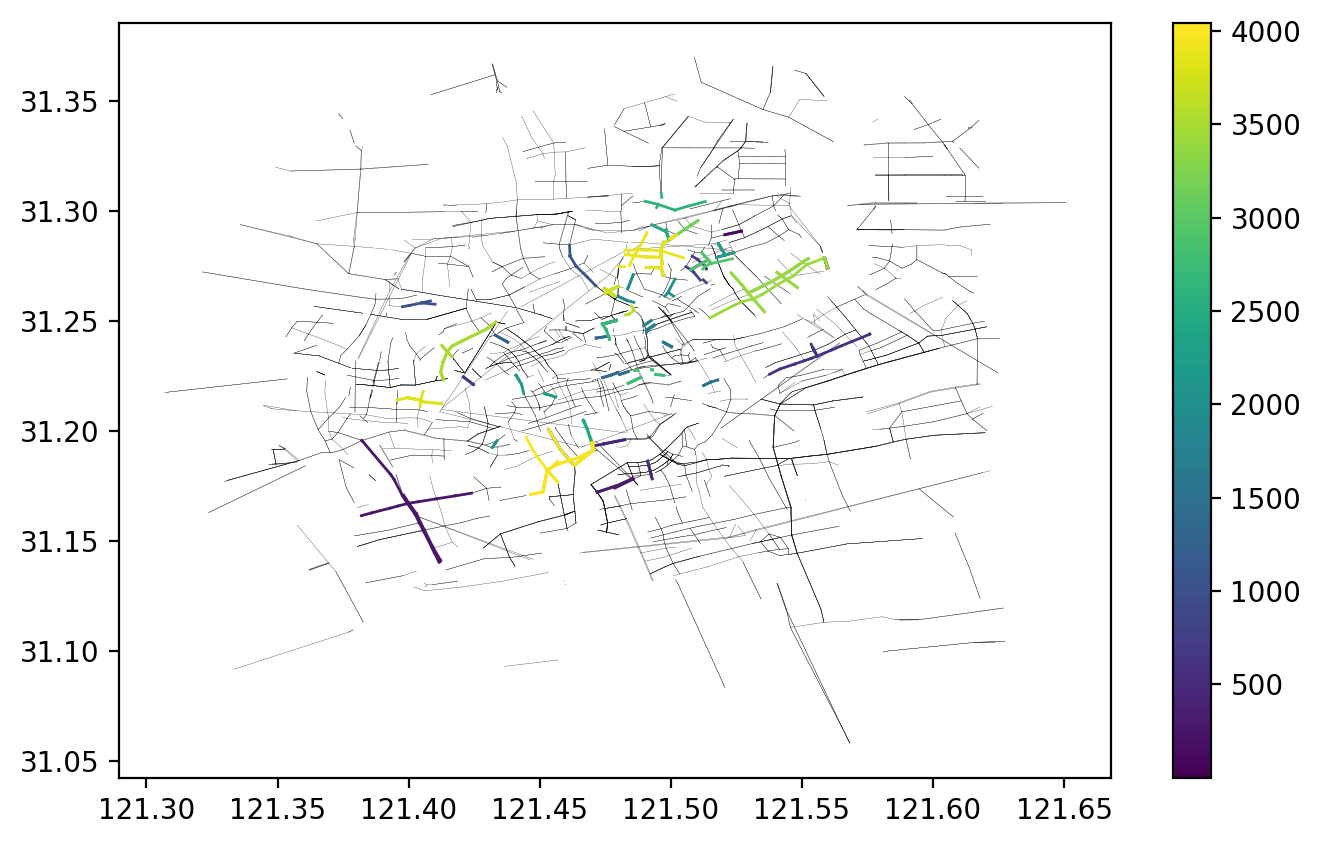

In [101]:
item_sets=[]
for s in result:
    flag=True
    for cmps in result:
        if s.items<cmps.items:
            flag=False
            break
    if flag:
        item_sets.append(s)

import matplotlib.pyplot as plt
from matplotlib import cm,colors
ref=node_dict_amap
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
cmap = cm.get_cmap('viridis', 100)
for road in road_zip.keys():
    if road not in road_edges:
        continue
    for edge in road_edges[road]:
        vi,vj=edge[0],edge[1]
        ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='black',linewidth=.1)
for no,s in enumerate(item_sets):
    cindex=float(no)/float(len(item_sets))
    for rid in s.items:
        road=list(road_zip.keys())[rid]
        for edge in road_edges[road]:
            vi,vj=edge[0],edge[1]
            ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color=cmap(cindex),linewidth=1)
norm = colors.Normalize(vmin=minium, vmax=maxium)
im = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im,ax=ax) 
fig.show()

## 事件聚类

### 构建事件向量

In [101]:
import numpy as np
vectors=np.zeros((len(cjst_events),np.array(list(road_zip.values())).shape[2]))
for no,event in enumerate(cjst_events):
    for shot in event.cjst_seq:
        vectors[no][shot['time']]=len(shot['rids'])

In [102]:
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

def patternDistance(s1,s2):
    p1=np.zeros_like(s1)
    p2=np.zeros_like(s2)
    for i in range(1,len(s1)):
        if s1[i-1]<s1[i]:
            p1[i-1]=1
        elif s1[i-1]>s1[i]:
            p1[i-1]=-1
        else:
            p1[i-1]=0
    for i in range(1,len(s2)):
        if s2[i-1]<s2[i]:
            p2[i-1]=1
        elif s2[i-1]>s2[i]:
            p2[i-1]=-1
        else:
            p2[i-1]=0
    sum=0
    for i in range(min(len(s1),len(s2))):
        sum+=abs(s1[i]-s2[i])
    return sum

bar = ProgressBar(widgets=widgets, maxval=len(data)*len(data)).start()
similar_matrix=np.zeros((len(vectors),len(vectors)))
for i in range(len(vectors)):
    for j in range(i,len(vectors)): 
        similar_matrix[i][j]=patternDistance(vectors[0],vectors[1])
        similar_matrix[j][i]=similar_matrix[i][j]
        bar.update(i*len(vectors)+j+1)
bar.finish()

Progress: 100% |##############| Elapsed Time: 0:03:23 Time: 0:03:23   4.99 kB/s


In [107]:
import math
affinity_matrix=[[0 for i in range(len(similar_matrix))] for j in range(len(similar_matrix))]
for i in range(len(similar_matrix)):
    for j in range(i,len(similar_matrix)):
        affinity_matrix[i][j]=math.exp(-similar_matrix[i][j])
        affinity_matrix[j][i]=affinity_matrix[i][j]

In [139]:
from sklearn.cluster import SpectralClustering
n_clusters=3
clustering = SpectralClustering(n_clusters=n_clusters,
                                affinity='precomputed',
                                eigen_solver='arpack',
                                random_state=0,
                                assign_labels='kmeans').fit(affinity_matrix)
clusters=[[] for _ in range(n_clusters)]

cluster_vectors=np.zeros((12,np.array(list(road_zip.values())).shape[2]))

for i,event in enumerate(cjst_events):
    label=clustering.labels_[i]
    clusters[label].append(event)
    cluster_vectors[label]+=vectors[i]
for i in range(len(cluster_vectors)):
    print(i,cluster_vectors[i])

0 [ 0.  0.  0.  1.  1.  1.  2.  2.  1.  2.  1.  2.  1.  1.  2.  2.  2.  4.
  3.  3.  1.  0.  0.  1.  1.  1.  2.  4.  4.  2.  3.  7.  6.  5.  7.  6.
  7.  5.  5.  6.  7.  5.  7.  6.  5.  5.  6.  6.  9.  8.  7.  7.  6.  6.
  5.  6.  2.  2.  3.  2.  5.  4.  3.  2.  3.  6.  4.  2.  3.  6.  3.  6.
  5.  6.  3.  2.  4.  4.  4.  4.  4.  2.  2.  3.  6.  3.  5.  3.  0.  1.
  2.  1.  2.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  4.  5.  5.  3.  5.  4.  4.  5.  6.  4.  4.  5.  6.  8.  7.  7.  7.  5.
  9.  9.  9.  8.  5.  3.  2.  3.  8.  8.  6.  5.  8.  9.  9.  3.  3.  4.
  6.  2.  3.  3.  4.  3.  4.  5.  9.  7. 10. 11. 11. 10. 12. 15. 20. 15.
 17. 15. 13. 15.  7.  6.  3.  2.  1.  2.  3.  4.  2.  1.  3.  3.  6. 11.
  9. 13. 12.  9. 14.  8.  9. 13. 11.  9.  7.  7.  7.  7.  7.  2.  3.  6.
  8.  4.  6.  4.  5.  5.  5.  2.  3.  1.  1.  1.  1.  2.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1 [0. 1. 3. 1. 2. 2. 2. 3. 5. 5. 4. 5. 4. 1. 2. 2. 3. 2. 2. 2. 2. 1. 1. 

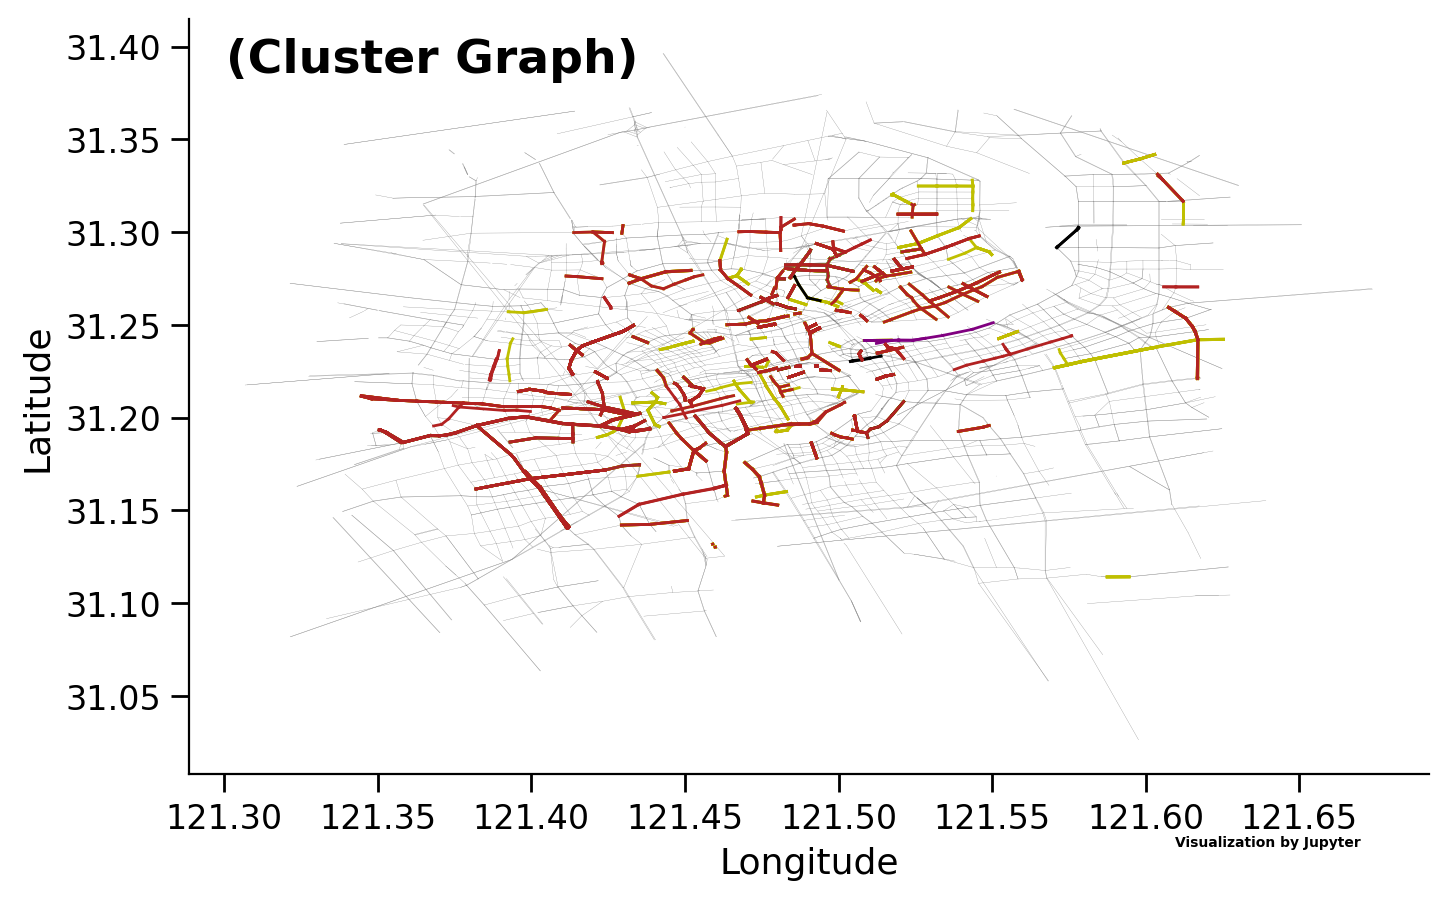

In [134]:
import matplotlib.pyplot as plt
colors=['r','g','b','y','pink','brown','orange','black','purple','olivedrab','aqua','firebrick']
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='grey',linewidth=.1)
for no in range(len(clusters)):
    for event in clusters[no]:
        roads=[]
        for shot in event.cjst_seq:
            roads.extend(shot['rids'])
        roads=list(set(roads))
        for road in roads:
            edges=road_edges[list(road_zip.keys())[road]]
            for edge in edges:
                a=edge[0]
                b=orthogonal_list[a][1][edge[1]][1]
                ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=colors[no],linewidth=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Cluster Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

In [75]:
def showEvent(i):
    event=cjst_events[i]
    print(event.date)
    for seq in event.cjst_seq:
        print('time',5+5*seq['time']//60,':',5*seq['time']%60,end=' ')
        for rid in seq['rids']:
            print(list(road_zip.keys())[rid][0],end=' ')
        print('')


revs_dict={}
for i in range(len(cjst_events)):
    for seq in cjst_events[i].cjst_seq:
        for rid in seq['rids']:
            if rid not in revs_dict:
                revs_dict[rid]=[i]
            elif i not in revs_dict[rid]:
                revs_dict[rid].append(i)
print(len(revs_dict))
for key,value in revs_dict.items():
    print(key,list(road_zip.keys())[key][0],'\t',len(value))

235
69 华申路 	 11
68 华申路 	 11
279 东葛路 	 2
278 东葛路 	 2
785 塘桥新路 	 2
784 塘桥新路 	 2
798 福佑路 	 35
773 福佑路 	 60
862 崂山路 	 5
864 栖霞路 	 4
863 崂山路 	 4
934 瑞虹路 	 9
936 新港路 	 6
927 临平路 	 5
935 瑞虹路 	 8
967 天平路 	 5
966 天平路 	 34
972 武康路 	 34
974 复兴西路 	 27
970 湖南路 	 10
1016 武胜路 	 21
624 人民大道 	 67
625 人民大道 	 67
60 康梧路 	 1
208 锦绣路 	 2
59 康梧路 	 1
176 宛平南路 	 7
152 龙华路 	 7
632 天目东路 	 26
631 天目东路 	 26
703 芷江支路 	 20
702 芷江支路 	 55
813 金港路 	 5
819 锦绣东路 	 4
812 金港路 	 6
404 锦绣东路 	 2
403 锦绣东路 	 2
901 天通庵路 	 4
963 建国西路 	 51
968 乌鲁木齐南路 	 51
64 富特中路 	 2
63 富特中路 	 8
517 密云路 	 11
525 政修路 	 4
493 玉田路 	 25
518 密云路 	 9
513 长岭路 	 64
92 延吉西路 	 64
512 抚顺路 	 15
501 铁岭路 	 13
514 长岭路 	 13
1009 巨鹿路 	 47
956 常熟路 	 56
954 宝庆路 	 56
282 富特南路 	 6
302 昌邑路 	 2
847 银城路 	 3
613 前程路 	 12
612 前程路 	 12
916 海门路 	 5
836 海门路 	 7
910 东长治路 	 4
108 黎平路 	 16
107 黎平路 	 16
843 东泰路 	 14
842 东泰路 	 14
790 潍坊西路 	 25
789 潍坊西路 	 25
749 世博村路 	 12
746 华丰路 	 18
751 半淞园路 	 2
738 龙华东路 	 3
944 日晖东路 	 43
755 局门路 	 6
186 枫林路 	 36
766 黄陂南路 	 6
172 龙腾大道 	 7
900 天通庵

In [288]:
for i in revs_dict[791]:
    showEvent(i)

6
time 5 : 1 泰康路 
time 5 : 2 思南路 
time 5 : 3 南昌路 思南路 
time 5 : 4 南昌路 泰康路 兴业路 思南路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业路 思南路 
time 6 : 15 南昌路 泰康路 兴业路 思南路 
time 6 : 16 南昌路 兴业路 思南路 
time 6 : 17 泰康路 思南路 
time 6 : 18 南昌路 泰康路 思南路 
time 6 : 19 南昌路 兴业路 
6
time 5 : 3 思南路 
time 5 : 4 南昌路 泰康路 思南路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业路 思南路 
time 6 : 15 南昌路 泰康路 兴业路 思南路 
time 6 : 16 南昌路 兴业路 思南路 
time 6 : 17 泰康路 思南路 
time 6 : 18 南昌路 泰康路 思南路 
time 6 : 19 南昌路 兴业路 
6
time 5 : 3 兴业路 
time 5 : 4 兴业路 南昌路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业

time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南

time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路

time 8 : 44 黄陂南路 岳阳路 南昌路 兴业路 
time 8 : 45 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 46 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 8 : 47 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 48 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 49 兴业路 黄陂南路 岳阳路 泰康路 思南路 
time 9 : 50 自忠路 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 51 自忠路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 52 兴业路 黄陂南路 岳阳路 永嘉路 南昌路 泰康路 思南路 
time 9 : 53 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 9 : 54 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 9 : 55 乌鲁木齐中路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 56 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 57 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 58 兴业路 黄陂南路 岳阳路 南昌路 泰康路 
time 9 : 59 黄陂南路 兴业路 岳阳路 南昌路 
time 10 : 0 自忠路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 茂名南路 
time 10 : 1 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 10 : 2 兴业路 黄陂南路 岳阳路 永嘉路 南昌路 泰康路 思南路 
time 10 : 3 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 10 : 4 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 10 : 5 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10

time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 7 : 24 岳阳路 
time 7 : 25 岳阳路 
time 7 : 26 岳阳路 
time 7 : 27 岳阳路 
time 7 : 28 岳阳路 汾阳路 
time 7 : 29 岳阳路 
time 7 : 30 岳阳路 
time 7 : 31 岳阳路 
time 7 : 32 岳阳路 
time 7 : 33 岳阳路 
time 7 : 34 岳阳路 
time 7 : 35 岳阳路 汾阳路 
time 8 : 36 岳阳路 
time 8 : 37 岳阳路 
time 8 : 38 永嘉路 岳阳路 
time 8 : 39 岳阳路 
time 8 : 40 岳阳路 汾阳路 
time 8 : 41 岳阳路 
time 8 : 42 岳阳路 汾阳路 
time 8 : 43 岳阳路 
time 8 : 44 岳阳路 
time 8 : 45 岳阳路 汾阳路 
time 8 : 46 岳阳路 汾阳路 
time 8 : 47 岳阳路 汾

time 10 : 1 岳阳路 汾阳路 
time 10 : 2 永嘉路 岳阳路 
time 10 : 3 岳阳路 茂名南路 乌鲁木齐南路 
time 10 : 4 岳阳路 汾阳路 南昌路 
time 10 : 5 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10 : 10 岳阳路 汾阳路 南昌路 
time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永

time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳

time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 7 : 34 泰康路 
time 7 : 35 泰康路 思南路 
time 8 : 36 南昌路 泰康路 思南路 
time 8 : 37 兴业路 泰康路 思南路 
time 8 : 38 兴业路 泰康路 复兴中路 思南路 
time 8 : 39 黄陂南路 兴业路 复兴中路 思南路 
time 8 : 40 兴业路 黄陂南路 汾阳路 复兴中路 南昌路 泰康路 思南路 
time 8 : 41 兴业路 黄陂南路 岳阳路 南昌路 思南路 
time 8 : 42 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 43 黄陂南路 岳阳路 南昌路 
time 8 : 44 黄陂南路 岳阳路 南昌路 兴业路 
time 8 : 45 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 46 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 8 : 47 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 48 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 49 兴业路 黄陂南路 岳阳路 泰康路 思南路 
time 9 : 50 自忠路 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 51 自忠路 兴业路 黄

time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 

time 9 : 58 兴业路 南昌路 泰康路 
time 9 : 59 兴业路 南昌路 
time 10 : 0 兴业路 南昌路 茂名南路 
time 10 : 1 兴业路 南昌路 思南路 
time 10 : 2 兴业路 南昌路 泰康路 思南路 
time 10 : 3 兴业路 南昌路 茂名南路 泰康路 思南路 
time 10 : 4 兴业路 南昌路 泰康路 思南路 
time 10 : 5 兴业路 南昌路 泰康路 思南路 
time 10 : 6 兴业路 泰康路 
time 10 : 7 兴业路 泰康路 
time 10 : 8 兴业路 泰康路 
time 10 : 9 兴业路 南昌路 泰康路 
time 10 : 10 南昌路 
time 10 : 11 南昌路 兴业路 思南路 
time 11 : 12 南昌路 泰康路 兴业路 思南路 
time 11 : 13 南昌路 兴业路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴

time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 

time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南

time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 

time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10 : 10 岳阳路 汾阳路 南昌路 
time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路

time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南

time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16

time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 

time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康

time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌

time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路

time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 9 : 59 乌鲁木齐北路 
time 10 : 0 乌鲁木齐北路 
time 10 : 1 乌鲁木齐中路 乌鲁木齐北路 
time 10 : 2 长乐路 乌鲁木齐北路 乌鲁木齐南路 
time 10 : 3 常熟路 富民路 茂名南路 乌鲁木齐南路 
time 10 : 4 南昌路 常熟路 
time 10 : 5 南昌路 兴业路 思南路 
time 10 : 6 兴业路 泰康路 
time 10 : 7 兴业路 泰康路 
time 10 : 8 兴业路 泰康路 
time 10 : 9 兴业路 南昌路 泰康路 
time 10 : 10 南昌路 
time 10 : 11 南昌路 兴业路 思南路 
time 11 : 12 南昌路 泰康路 兴业路 思南路 
time 11 : 13 南昌路 兴业路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业

time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路

time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23

time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路

time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 

time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 

time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 

time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 15 : 9 南昌路 
time 15 : 10 南昌路 兴业路 思南路 
time 15 : 11 兴业路 泰康路 思南路 
time 16 : 12 兴业路 泰康路 思南路 
time 16 : 13 兴业路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 南昌路 泰康路 思

time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 17 : 27 泰康路 
time 17 : 28 思南路 
time 17 : 29 泰康路 思南路 
time 17 : 30 南昌路 泰康路 
time 17 : 31 兴业路 思南路 
time 17 : 32 兴业路 泰康路 思南路 
time 17 : 33 兴业路 泰康路 思南路 
time 17 : 34 兴业路 泰康路 思南路 
time 17 : 35 兴业路 泰康路 思南路 
time 18 : 36 兴业路 南昌路 泰康路 
time 18 : 37 南昌路 泰康路 思南路 
time 18 : 38 南昌路 兴业路 泰康路 思南路 
time 18 : 39 南昌路 泰康路 兴业路 思南路 
time 18 : 40 南昌路 兴业路 泰康路 思南路 
time 18 : 41 兴业路 茂名南路 泰康路 思南路 
time 18 : 42 兴业路 泰康路 思南路 
time 18 : 43 兴业路 泰康路 思南路 
time 18 : 44 兴业路 泰康路 思南路 
time 18 : 45 兴业路 南昌路 思南路 
time 18

time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 21 : 16 泰康路 
time 21 : 17 思南路 
time 21 : 18 南昌路 泰康路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 


In [249]:
print(list(road_zip.values())[785][0])


[[1.         0.66666667]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.74074074]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.66666667]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]


# 道路演化分析

In [5]:
import matplotlib.pyplot as plt
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

data=np.array(list(road_zip.values()))[:,:,:,0]
data=data.swapaxes(0,1)
data=np.concatenate(data,axis=1)
data=data.T
ref=node_dict_amap
status2color=['black','green','orange','red']

bar = ProgressBar(widgets=widgets, maxval=len(data)).start()
for t,tdata in enumerate(data):
    if t<6080:
        bar.update(t+1)
        continue
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    for i,road in enumerate(keys):
        if road in road_edges:
            for edge in road_edges[road]:
                a=edge[0]
                b=orthogonal_list[a][1][edge[1]][1]
                ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=status2color[int(tdata[i])],linewidth=1)
    fig.savefig(f'images/img{t:0>7d}.png')
    plt.close(fig)
    bar.update(t+1)
bar.finish()

Progress: 100% |##############| Elapsed Time: 0:01:02 Time: 0:01:02  97.54  B/s


合成视频

In [140]:
import cv2
import os
file_list=sorted(os.listdir('images'))
file_list.pop(0)

fourcc=cv2.VideoWriter_fourcc(*'XVID')
videowrite=cv2.VideoWriter('evolution.mp4',fourcc,5,(1600,1000))#20是帧数，size是图片尺寸
print(videowrite.isOpened())
img_array=[]
for filename in file_list:
    img = cv2.imread('images/'+filename)
    if img is None:
        print(f'{filename} do not exist!')
        continue
    img_array.append(img)
for img in img_array:
    videowrite.write(img)
videowrite.release()
print('true')

True
true
